# BERT for multi-label classification

In [3]:
import pandas as pd

pre_merged_anime = pd.read_csv('../data/pre_merged_anime.csv')
print(pre_merged_anime.shape)
pre_merged_anime.head(2)

(16206, 19)


,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Premiered,Producers,Studios,Source,Duration,Rating,Ranked,Members,Favorites,Completed,On-Hold,synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,Spring 1998,Bandai Visual,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,1251960,61971,718161,71513,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,Unknown,"Sunrise, Bandai Visual",Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,273145,1174,208333,1935,"other day, another bounty—such is the life of ..."


In [4]:
import re
import string

def clean_text(text):
    # Remove non-printable characters
    text = ''.join(filter(lambda x: x in string.printable, text))
    # Replace multiple whitespace characters with a single space
    text = re.sub(r'\s{2,}', ' ', text).strip()
    return text.strip()

# WITH NO GENRES
def get_anime_description(anime_row):
    """
    Generates a custom description for an anime title based on various features from the input data.

    :param anime_row: A row from the MyAnimeList dataset containing relevant anime information.
    :return: A formatted string containing a custom description of the anime.
    """

    # Determine the type of anime (TV show or other)
    anime_type = "TV Show" if anime_row["Type"] == "TV" else anime_row["Type"]

    # Create a formatted description using the relevant features from the input data
    description = (
        f"{anime_row['Name']} is a {anime_type}.\n"
        f"Synopsis: {anime_row['synopsis']}\n"
        f"It was produced by {anime_row['Producers']} and it is from {anime_row['Studios']} Studio.\n"
        f"Its source is {anime_row['Source']}.\n"
        f"It premiered in {anime_row['Premiered']}."
    )

    return clean_text(description)


In [5]:
print(clean_text(get_anime_description(pre_merged_anime.iloc[0])))

Cowboy Bebop is a TV Show.
Synopsis: In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travelsEin, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wongthe crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Be

In [6]:
# Create a new column in our merged anime dataframe for our new descriptions
pre_merged_anime['generated_description'] = pre_merged_anime.apply(get_anime_description, axis=1)


In [7]:
from functools import reduce

all_genres = list(reduce(lambda y, z: y + z, pre_merged_anime['Genres'].map(lambda x: x.split(', '))))
all_genres[:3]

['Action', 'Adventure', 'Comedy']

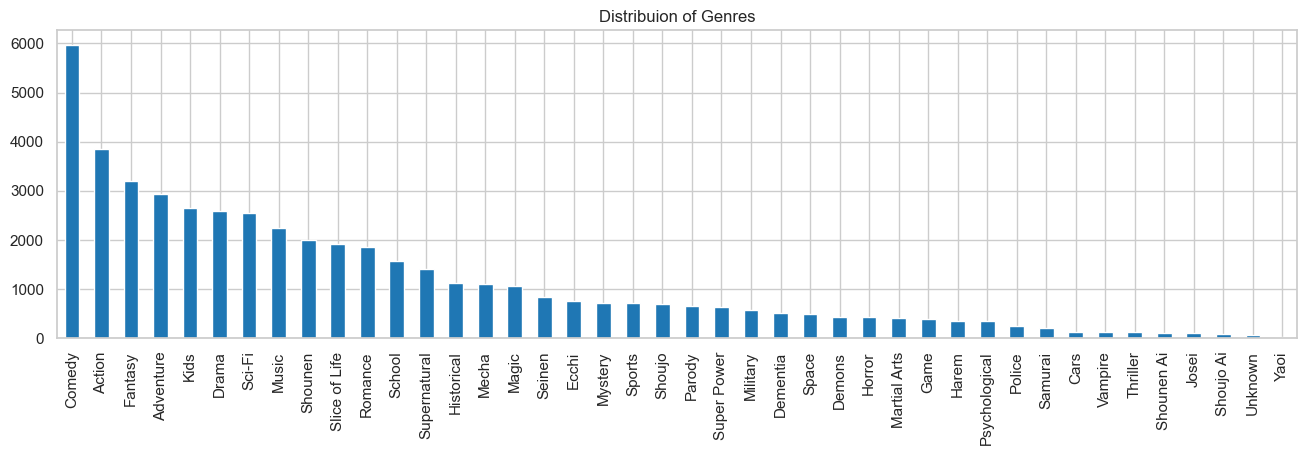

In [8]:
pd.Series(all_genres).value_counts().plot(kind='bar', title='Distribuion of Genres', figsize=(16, 4))

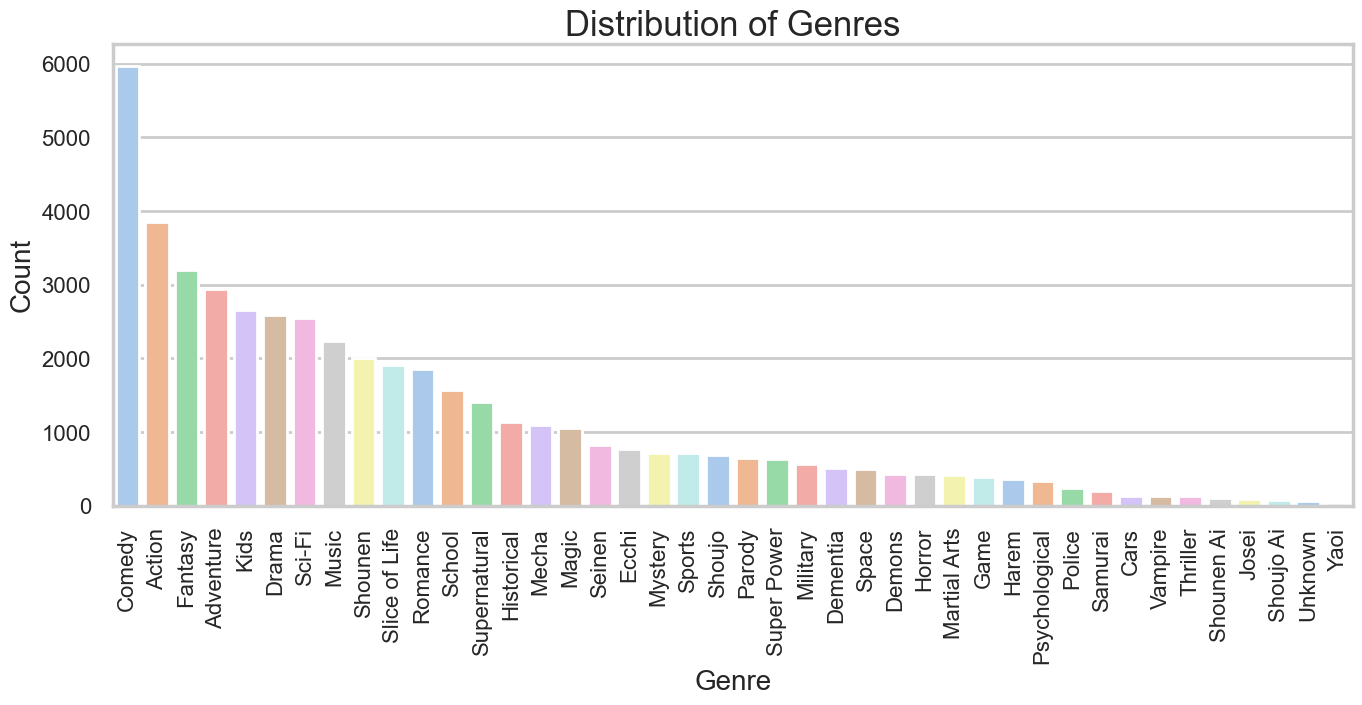

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style and context
sns.set_style('whitegrid')
sns.set_context('poster')  # Increase the base size of all fonts

# Prepare the data
genre_counts = pd.Series(all_genres).value_counts()

# Create the plot
plt.figure(figsize=(16, 6))

colors = sns.color_palette('pastel')[0:len(genre_counts)]
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette=colors)

plt.title('Distribution of Genres', fontsize=25)  # Increase fontsize for title
plt.xlabel('Genre', fontsize=20)  # Increase fontsize for x label
plt.ylabel('Count', fontsize=20)  # Increase fontsize for y label
plt.xticks(rotation=90, fontsize=16)  # Increase fontsize for x ticks
plt.yticks(fontsize=16)  # Increase fontsize for y ticks

# Show and save the plot
plt.savefig('genre_distribution.png', dpi=1000, bbox_inches='tight')
plt.show()


# Downsampling semantically similar texts

This can help consistency if our task is 'ill-defined' meaning that a similar input description yields different genres because the description doesn't have enough information for the model to distinguish between the genres

In [2]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Our model that encodes semantically similar texts to be near each other
downsample_model = SentenceTransformer('paraphrase-distilroberta-base-v1')
def filter_semantically_similar_texts(texts, similarity_threshold=0.8):
    # Generate embeddings for all texts. These embeddings are representations of 
    # the texts in a high dimensional space, created in such a way that semantically 
    # similar texts are close to each other in this space.
    embeddings = downsample_model.encode(texts)

    # Calculate the cosine similarity between all pairs of text embeddings. The 
    # result is a matrix where the cell at the intersection of row i and column j
    # represents the cosine similarity between the embeddings of texts[i] and texts[j].
    similarity_matrix = cosine_similarity(embeddings)
    
    # Set the diagonal elements of the similarity matrix to 0, because they represent
    # the similarity of each text with itself, which is always 1.
    np.fill_diagonal(similarity_matrix, 0)

    # Initialize an empty list to store the texts that are not too similar to any 
    # other text.
    filtered_texts = []
    
    # Initialize a set to store the indices of the texts that are too similar to
    # another text.
    excluded_indices = set()

    # For each text...
    for i, text in enumerate(texts):
        # If the current text is not too similar to any other text...
        if i not in excluded_indices:
            # Add it to the list of non-similar texts
            filtered_texts.append(text)
            
            # Find the indices of the texts that are too similar to the current text
            similar_texts_indices = np.where(similarity_matrix[i] > similarity_threshold)[0]
            
            # Exclude these texts from further consideration
            excluded_indices.update(similar_texts_indices)

    return filtered_texts

texts = [
    "This is a sample text.",
    "This is another sample text.",
    "This is a similar text.",
    "This is a completely different text.",
    "This text is quite alike.",
]

filtered_texts = filter_semantically_similar_texts(texts, similarity_threshold=0.9)
print(filtered_texts)


['This is a sample text.', 'This is a similar text.', 'This is a completely different text.', 'This text is quite alike.']


In [18]:
unique_labels = sorted(list(set(reduce(lambda y, z: y + z, pre_merged_anime['Genres'].map(lambda x: x.split(', '))))))

print(len(unique_labels), unique_labels)

42 ['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural', 'Thriller', 'Unknown', 'Vampire', 'Yaoi']


In [19]:
id2label = {idx:label for idx, label in enumerate(unique_labels)}
label2id = {label:idx for idx, label in enumerate(unique_labels)}
     

In [20]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

MODEL = 'distilbert-base-uncased'

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    problem_type="multi_label_classification", 
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [21]:
import numpy as np
import torch

tokenizer = AutoTokenizer.from_pretrained(MODEL)

def preprocess_data(examples, text_col):
    one_hot_encoded_matrix = []
    text = examples[text_col]
    genres = examples["Genres"]
    for genre in genres:
        g = genre.split(', ')
        one_hot_encoded_row = [1 if label in g else 0 for label in unique_labels]
        one_hot_encoded_matrix.append(one_hot_encoded_row)

    # Convert the one_hot_encoded_matrix to a LongTensor
    one_hot_encoded_matrix = [torch.tensor(o, dtype=torch.float32) for o in one_hot_encoded_matrix]

    # Encode the text
    encoding = tokenizer(text, truncation=True, max_length=256)
    
    # Add labels
    encoding["labels"] = one_hot_encoded_matrix

    return encoding


In [22]:
from datasets import Dataset
anime_with_synopsis_dataset = Dataset.from_pandas(pre_merged_anime[['synopsis', 'Genres', 'generated_description']])

anime_with_synopsis_dataset = anime_with_synopsis_dataset.train_test_split(test_size=.2, seed=42)

In [23]:
anime_with_synopsis_dataset

DatasetDict({
    train: Dataset({
        features: ['synopsis', 'Genres', 'generated_description'],
        num_rows: 12964
    })
    test: Dataset({
        features: ['synopsis', 'Genres', 'generated_description'],
        num_rows: 3242
    })
})

In [24]:
from tqdm.auto import tqdm
DOWNSAMPLE_TRAIN = True

def downsample_dataset(dataset, text_col, similarity_threshold=0.95):

    filtered_texts = filter_semantically_similar_texts(dataset[text_col], similarity_threshold)
    return [d for d in dataset if d[text_col] in filtered_texts]

if DOWNSAMPLE_TRAIN:
    anime_with_synopsis_dataset['train'] = Dataset.from_pandas(pd.DataFrame(
        downsample_dataset(anime_with_synopsis_dataset['train'], text_col='generated_description')
    ))


In [25]:
description_encoded_dataset = anime_with_synopsis_dataset.map(
    lambda x: preprocess_data(x, 'generated_description'),
    batched=True, batch_size=128, remove_columns=['synopsis', 'Genres', 'generated_description']
)

description_encoded_dataset


Map:   0%|          | 0/12731 [00:00<?, ? examples/s]

Map:   0%|          | 0/3242 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12731
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3242
    })
})

In [26]:
description_encoded_dataset['train'][0]

{'input_ids': [101,
  14100,
  6172,
  23289,
  2003,
  1037,
  2694,
  2265,
  1012,
  19962,
  22599,
  1024,
  5595,
  2086,
  3283,
  1010,
  3287,
  6767,
  16136,
  6386,
  2124,
  2004,
  2601,
  7545,
  2716,
  2055,
  1996,
  1000,
  2058,
  23663,
  1010,
  1000,
  1037,
  10250,
  10631,
  24826,
  2015,
  2724,
  2008,
  3908,
  2028,
  1011,
  7891,
  1997,
  1996,
  2088,
  1012,
  1999,
  1996,
  2556,
  2154,
  1010,
  1996,
  11265,
  14971,
  6313,
  3029,
  5698,
  4003,
  11014,
  1996,
  2601,
  7545,
  1005,
  2373,
  2005,
  2037,
  2035,
  2021,
  7036,
  11174,
  1012,
  5292,
  6820,
  8294,
  1010,
  1037,
  4690,
  1011,
  26974,
  3165,
  1011,
  10681,
  10563,
  1010,
  22490,
  2015,
  1996,
  2516,
  1997,
  23289,
  3040,
  1024,
  1996,
  2711,
  2040,
  15536,
  14273,
  2015,
  1996,
  2373,
  1997,
  1996,
  8987,
  23289,
  6386,
  1010,
  10471,
  5214,
  1997,
  9846,
  1996,
  2601,
  7545,
  1012,
  2174,
  1010,
  1996,
  2116,
  23289,
  638

In [27]:
# 1 - (12731/12964) == ~2% reduction in text

In [28]:
# Import the necessary libraries
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, jaccard_score

# Define a function to compute several multi-label metrics
def multi_label_metrics(predictions, labels, threshold=0.5):
    # Initialize the sigmoid function which we'll use to transform our raw prediction values
    sigmoid = torch.nn.Sigmoid()
    
    # Apply sigmoid function to our predictions
    probs = sigmoid(torch.Tensor(predictions))
    
    # Create a binary prediction array based on our threshold
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    
    # Use actual labels as y_true
    y_true = labels
    
    # Compute F1 score, ROC AUC score, Accuracy, and Jaccard score
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average='micro')
    
    # Package the scores into a dictionary and return it
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'jaccard': jaccard}
    return metrics

# Define a function to compute metrics for predictions
def compute_metrics(p: EvalPrediction):
    # Extract the prediction values from the EvalPrediction object
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    
    # Compute the multi-label metrics for the predictions and actual labels
    result = multi_label_metrics(predictions=preds, labels=p.label_ids)
    
    # Return the results
    return result


In [29]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [30]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"genre-prediction",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,  # effective batch size of 64
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="jaccard",
)

trainer = Trainer(
    model,
    args,
    train_dataset=description_encoded_dataset["train"],
    eval_dataset=description_encoded_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.evaluate()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin


{'eval_loss': 0.6904123425483704,
 'eval_f1': 0.1369988265951448,
 'eval_roc_auc': 0.5286371930647538,
 'eval_accuracy': 0.0,
 'eval_jaccard': 0.07353662925759906,
 'eval_runtime': 13.2868,
 'eval_samples_per_second': 244.002,
 'eval_steps_per_second': 1.957}

In [31]:
trainer.train()

C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Jaccard
0,0.400100,0.216681,0.000000,0.500000,0.000000,0.000000
2,0.211600,0.188175,0.203728,0.557617,0.055521,0.113417
2,0.182600,0.166533,0.338586,0.605783,0.103640,0.203794
4,0.158800,0.154153,0.480100,0.673177,0.128624,0.315876
4,0.142700,0.147746,0.499447,0.681815,0.140654,0.332842
6,0.130400,0.144939,0.526030,0.699458,0.151141,0.356880
6,0.121400,0.143246,0.542068,0.710036,0.157619,0.371806
8,0.114000,0.141969,0.552849,0.718078,0.164096,0.382025
8,0.109500,0.142002,0.553577,0.717334,0.162862,0.382721
9,0.105200,0.141851,0.553381,0.717478,0.163788,0.382534


C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages

TrainOutput(global_step=990, training_loss=0.1574600369039208, metrics={'train_runtime': 1850.8541, 'train_samples_per_second': 68.784, 'train_steps_per_second': 0.535, 'total_flos': 8376362344234368.0, 'train_loss': 0.1574600369039208, 'epoch': 9.95})

# WITH FREEZING 

In [32]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    problem_type="multi_label_classification", 
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)

# Freeze everything up until the final 3 encoder layers
for name, param in model.named_parameters():
    if 'distilbert.transformer.layer.4' in name:
        break
    param.requires_grad = False


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [33]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"genre-prediction",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="jaccard",
)

trainer = Trainer(
    model,
    args,
    train_dataset=description_encoded_dataset["train"],
    eval_dataset=description_encoded_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.evaluate()

C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.6807237267494202,
 'eval_f1': 0.14032443173058803,
 'eval_roc_auc': 0.5350972708477946,
 'eval_accuracy': 0.0,
 'eval_jaccard': 0.07545640439916733,
 'eval_runtime': 13.0675,
 'eval_samples_per_second': 248.097,
 'eval_steps_per_second': 1.99}

In [34]:
trainer.train()

C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Jaccard
0,0.393300,0.215194,0.000000,0.500000,0.000000,0.000000
2,0.208600,0.186082,0.201892,0.556849,0.054904,0.112280
2,0.182700,0.169017,0.329711,0.602982,0.082048,0.197398
4,0.167000,0.158849,0.421964,0.644137,0.109809,0.267399
4,0.157300,0.153134,0.450384,0.657418,0.123689,0.290643
6,0.151100,0.150093,0.475401,0.669968,0.132634,0.311820
6,0.147700,0.147564,0.495744,0.681348,0.132943,0.329561
8,0.144800,0.146165,0.500547,0.683849,0.135102,0.333820
8,0.141900,0.145327,0.501811,0.684472,0.136336,0.334945
9,0.140000,0.145075,0.503441,0.685537,0.136952,0.336399


C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\sinan\anaconda3\envs\DL\lib\site-packages

TrainOutput(global_step=990, training_loss=0.17362880417794893, metrics={'train_runtime': 1286.7489, 'train_samples_per_second': 98.939, 'train_steps_per_second': 0.769, 'total_flos': 8376362344234368.0, 'train_loss': 0.17362880417794893, 'epoch': 9.95})

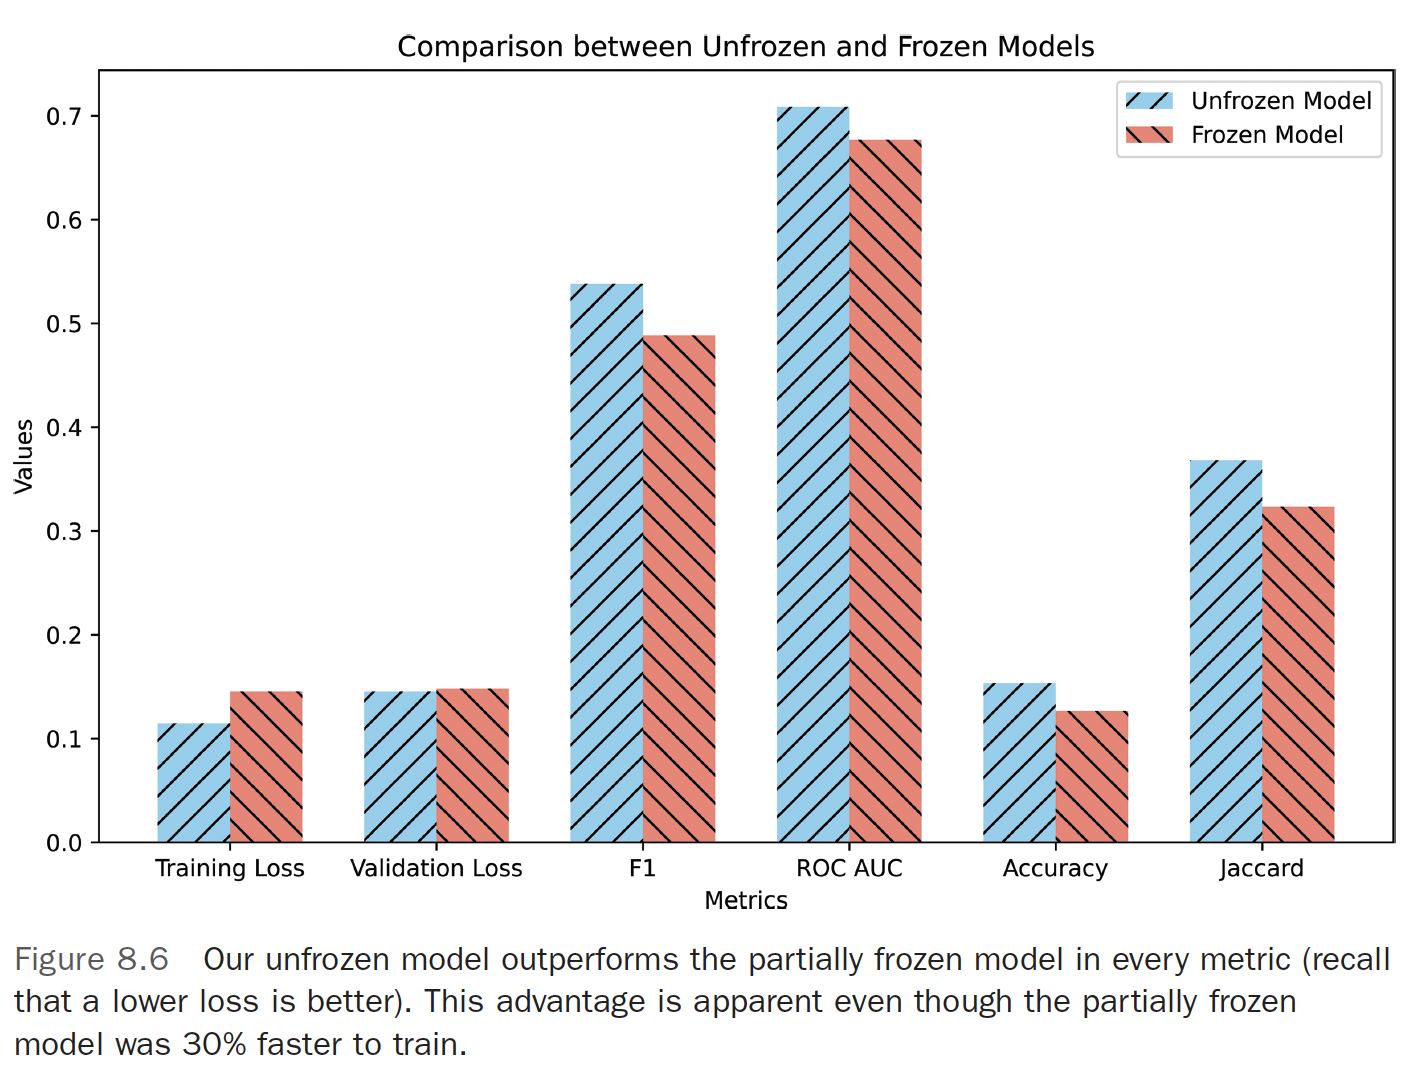

In [40]:
trainer.save_model()

In [42]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL)

trained_model = AutoModelForSequenceClassification.from_pretrained(
    f"genre-prediction", problem_type="multi_label_classification",
).eval()  # without eval, dropout layers randomly cut off neurons making the output non deterministic

classifier = pipeline(
    "text-classification",model=trained_model, tokenizer=tokenizer,
    return_all_scores=True
)


In [47]:
import random
random_animes = pre_merged_anime.sample(3)
texts = list(random_animes['generated_description'])
labels = list(random_animes['Genres'])


In [50]:
prediction = classifier(texts)
THRESHOLD = 0.5

prediction = [[label for label in p if label['score'] > THRESHOLD] for p in prediction]

for _text, scores, label in zip(texts, prediction, labels):
    print(_text)
    print('------------')
    for _score in sorted(scores, key=lambda x: x['score'], reverse=True):
        print(f'{_score["label"]}: {_score["score"]*100:.2f}%')
    
    print('actual labels: ', label)
    print('------------')
    

Mary Bell no Koutsuu Anzen is a OVA.
Synopsis: affic safety short starring the Hana no Mahoutsukai Mary Bell cast. The short was re-released on the Hana no Mahoutsukai Mary Bell DVD-Box Set in 2009.
It was produced by Unknown and it is from Unknown Studio.
Its source is Original.
It premiered in Unknown.
------------
Kids: 80.89%
actual labels:  Kids
------------
Lupin III: Sweet Lost Night - Mahou no Lamp wa Akumu no Yokan is a Special.
Synopsis: upin scores a "magic lamp" and finds it does hold a genie. However, the stroke of 7PM strikes, and that is the last thing he remembers. Finding himself in Singapore, Lupin must battle his way past the forces of Colonel Garlic and discover the secret behind the lamp. But every time the clock strikes 7PM, his memory is wiped clean! How can Lupin piece together this puzzle, when he can't even remember what he is doing?! (Source: Lupin III Encyclopedia)
It was produced by Tohokushinsha Film Corporation and it is from TMS Entertainment Studio.
Its